In [1]:
import pandas as pd 
import os
import tarfile
import numpy as np
from six.moves import urllib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
os.chdir('C:/Users/LG/Documents/Python Scripts')
DOWNLOAD_ROOT = "http://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

#Housing Data 받기
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
    
#Data Load
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

#Test set 만들기y
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [3]:
housing = load_housing_data()

In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


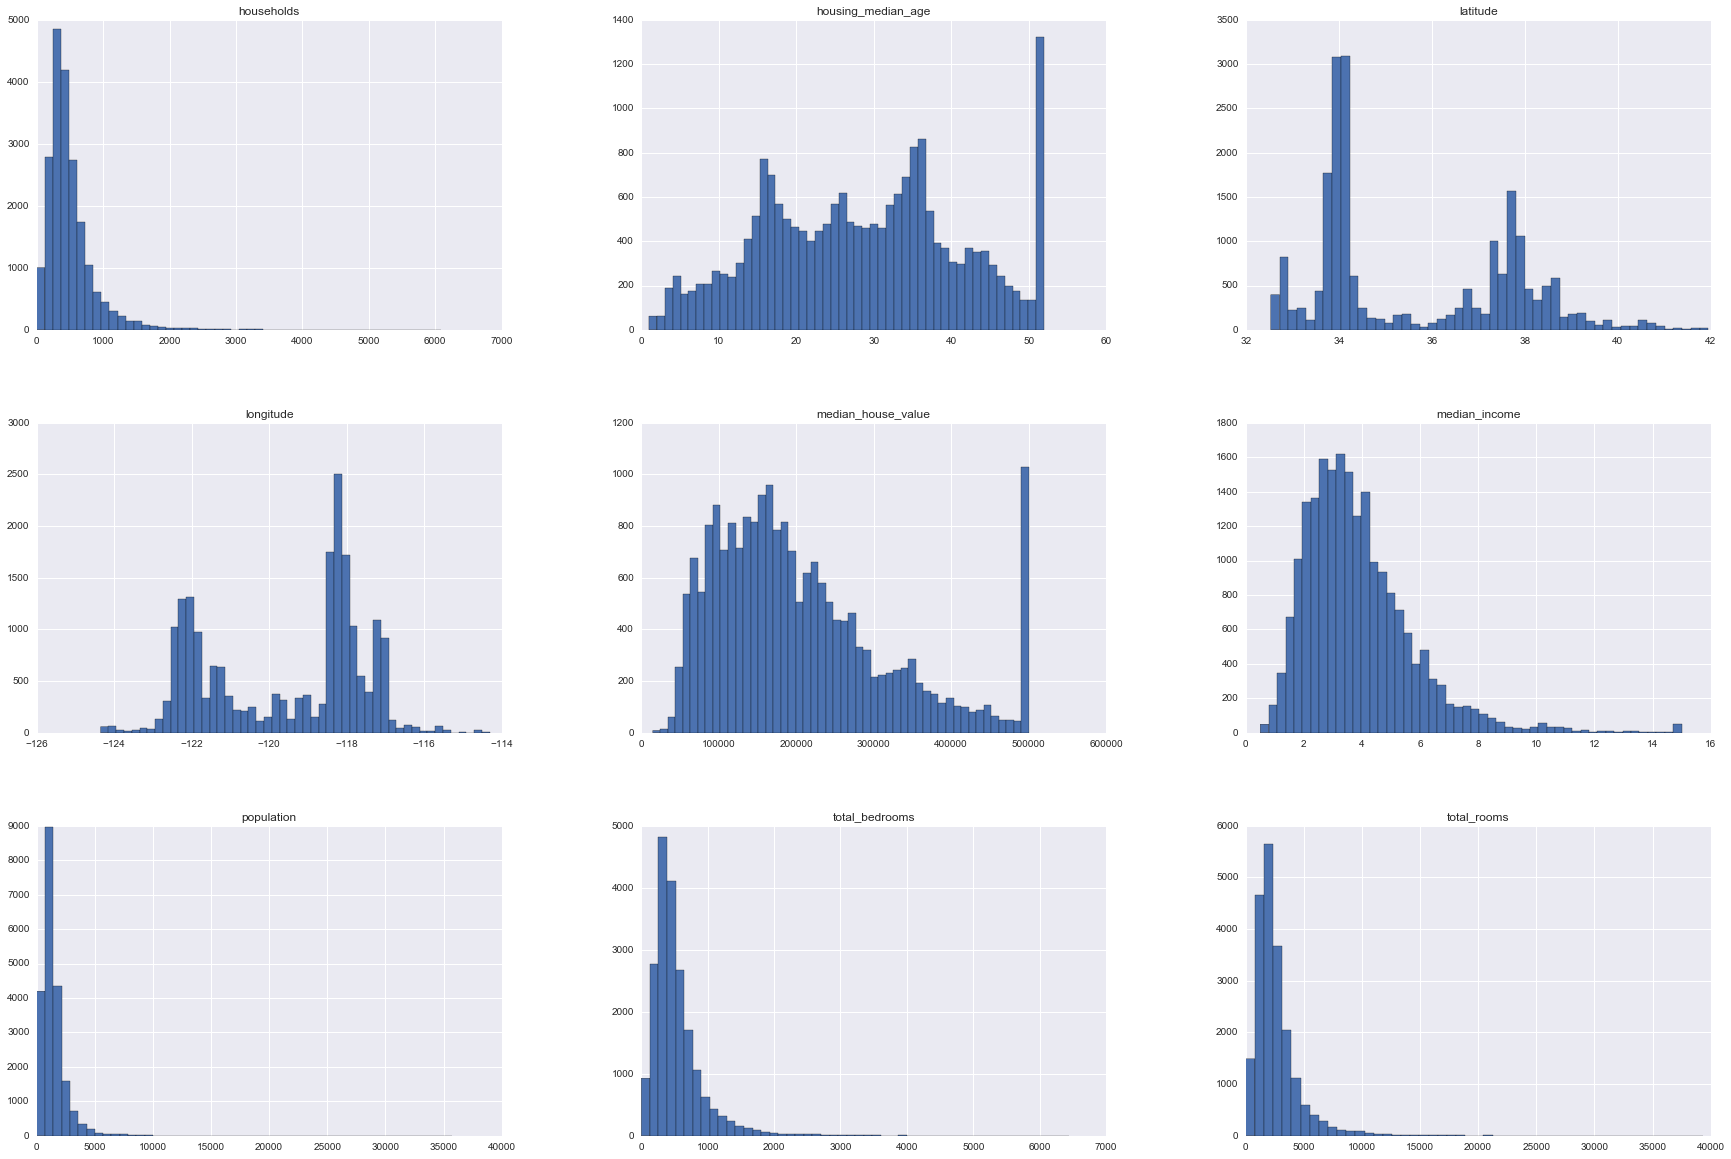

In [5]:
housing.hist(bins = 50, figsize = (30,20))
plt.show()

In [6]:
train_set, test_set = split_train_test(housing, 0.2)

### Random.seed 주긴 했는데 추가적인 Data 들어오면 다시 train, test 완전 다 섞여버린다. 어떻게 하면 막을 수 있지?

-. Index를 주어주고 추가되는 data는 항상 맨 뒤에 오도록 한다.

In [7]:
# Index에 Labeling 해줘서 추가 Data 들어오면 맨 뒤에 오게 하는 거
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash = hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [8]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [9]:
# Random으로 Sampling해서 train/test 얻는다. 
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

### Data가 많으면 Random sampling 잘 되는데 적으면 Sampling bias 발생할 수도 있다. 예를 들면 지역 별로 Data가 나누어 질 때 특정 지역의 Data가 더 많이 모인다든지. 
* Strtified sampling : Subgroup(strata)로 나누어서 가중치 줘서 sampling하는 것
 - Strata만들 때 너무 많이 만들면 안되고 각각 stratum은 충분히 커야 한다.  

In [10]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) #income_cat중에 5보다 작은 거 냅두고 나머진 5.0로 두고 바꾼다. 

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

In [11]:
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [12]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis = 1, inplace = True)

### Data 복사해서 Visualizing 한다. 

In [13]:
housing = strat_train_set.copy()

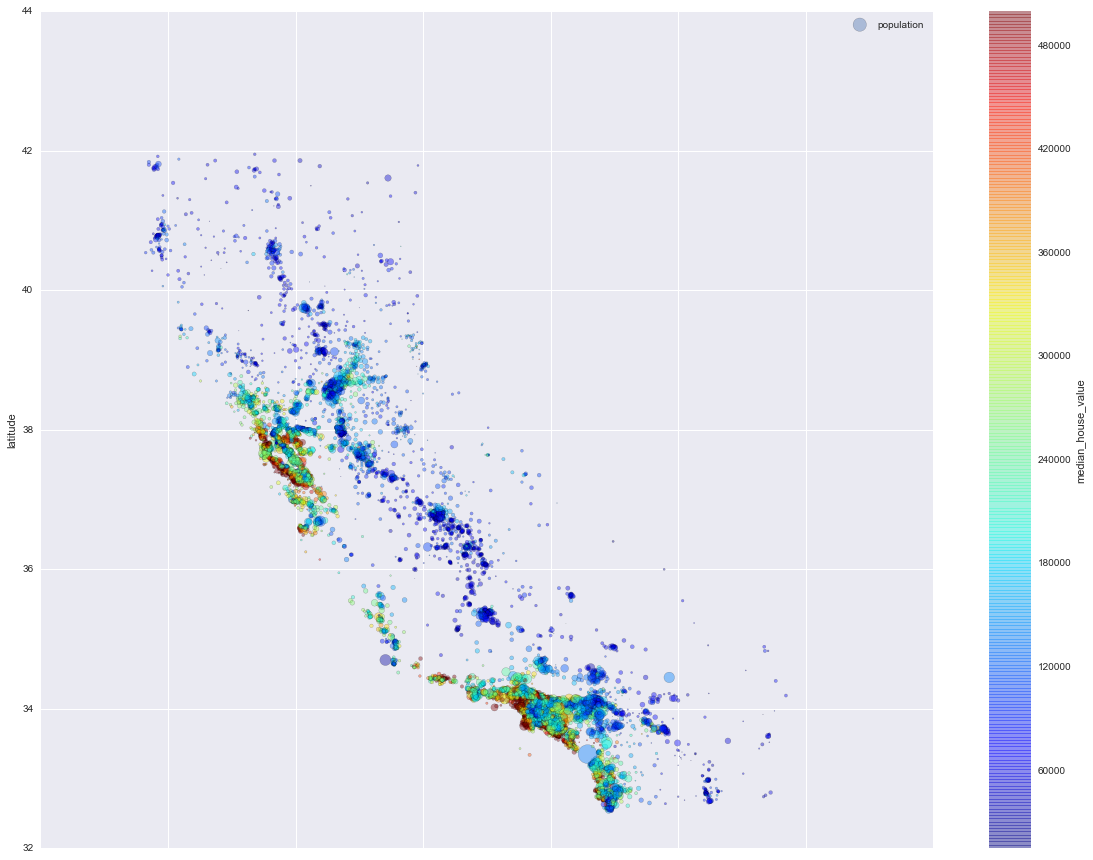

In [14]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4, 
            s = housing['population']/100, label = 'population', c = 'median_house_value',
            cmap = plt.get_cmap('jet'), colorbar = True, figsize = (20,15)
             )
plt.legend()

In [15]:
# Correlation 구하기
corr_matrix = housing.corr()

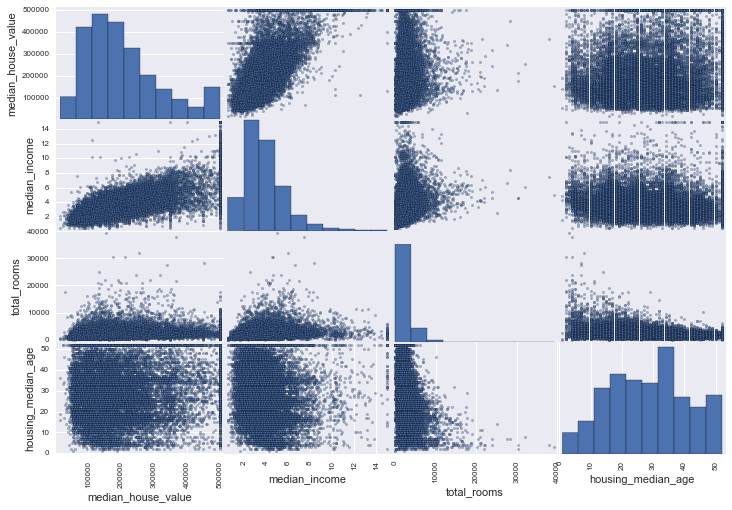

In [16]:
from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize = (12, 8))
plt.show()

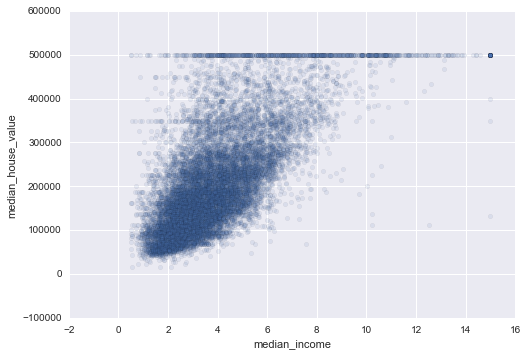

In [17]:
housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)

In [18]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [19]:
#개별 항목으로 의미 적은 attribute들 하나로 합친다.
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [20]:
housing.corr()['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [21]:
# training set에서 Label 따로 뺀다. (X, Y 분리)
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

In [22]:
# Data Cleaning
housing.dropna(subset = ['total_bedrooms']) # option 1
housing.drop('total_bedrooms', axis = 1) # option 2
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median) # option 3 

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
19480     588.0
8879      317.0
13685     293.0
4937      465.0
4861      229.0
16365     951.0
19684     559.0
19234     501.0
13956     582.0
2390      495.0
11176     649.0
15614     545.0
2953      251.0
13209     409.0
6569      261.0
5825      913.0
18086     538.0
16718     945.0
13600     278.0
13989     444.0
15168     190.0
6747      563.0
7398      366.0
5562      133.0
16121     416.0
          ...  
12380     767.0
5618       24.0
10060     539.0
18067     438.0
4471      797.0
19786     300.0
9969      393.0
14621    1051.0
579       302.0
11682    1615.0
245       460.0
12130     537.0
16441     544.0
11016     428.0
19934     422.0
1364       34.0
1236      829.0
5364      272.0
11703     300.0
10356     449.0
15270     515.0
3754      373.0
12166     756.0
6003      932.0
7364      212.0
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, dt

In [23]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy = 'median')
housing_num = housing.drop('ocean_proximity', axis = 1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [24]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [25]:
X = imputer.transform(housing_num)

In [26]:
X.shape
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

In [27]:
# Text → Categorical Attribute로 변환
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)

### Label encoder로 encoding하면 0~4 숫자 사이에 가깝고 먼게 있어서 independent하지 않다. 그래서 one-hot encoding 한다.
* One-hot encoding할 때는 먼저 label이 숫자로 바뀌어 있어야 한다.

In [28]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
#Scipy Sparse matrix로 저장이 되는데, 메모리 아끼기 위해서 임. one-hot의 경우 
#죄다 0으로 가득차 있는데 거기에 메모리 할당하는게 아까워서 array로 하려면 toarray.

#이건 위에 2단계로 한거 한번에 하는 거
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output = True)
housing_cat_1hot = encoder.fit_transform(housing_cat)

### Custom Transformer
* BaseEstimator 사용하는 거 알려주실 예정. 어디에 언제 쓰는 거지? 
 * 아래 내용은 Attribute 위에서 합친거처럼 하는건데, Class로 만들어서 사용하는 거고 이거 외에도 원하는대로 목적에 따라 설계 가능한 듯 (예제 더 봐야 이해 될듯여)


In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                    bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)            

In [30]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ..., 
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

### Feature Scaling
* Min-max scaling : value - min/max-min → 0~1 range
* Standardization : value - mean/variance

→ Feature scaling도 이전과 마찬가지로 training data에 국한되서 fit한다.

### Pipeline에 대한 설명 
* Pipeline은 각각의 Preprocessing에 대해 하나로 엮어서 진행되도록 도와준다. 
* Numerical value를 Categorical value로 바꾸는 것도 설계 잘하면 구현 가능하다. 

In [31]:
#앞에서 설명한 Pipeline 처럼 순서대로 전처리 진행한다. 신기하네.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy = 'median')), # missing value median 넣는거
        ('attribs_adder', CombinedAttributesAdder()), # Attribute 합치는 거 
        ('std_scaler', StandardScaler()), # Standardization 하는거
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [32]:
# Dataframe Select하는 거 Class
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [33]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)), # Data 선택, Numerical만.
        ('imputer', Imputer(strategy = 'median')), # Missing value median
        ('attribs_adder', CombinedAttributesAdder()), # 필요에 의해서 attribute 합치기
        ('std_scaler', StandardScaler()), # Standardization 
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)), # Data 선택, Categorical만
        ('label_binarizer', LabelBinarizer()), # One-hot encoding 한다. 
    ])

full_pipeline = FeatureUnion(transformer_list = [  # Pipeline 연결하기. 
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
    ])

In [34]:
# Data 전처리 전부다 한 번에 완료
housing_prepared = full_pipeline.fit_transform(housing)

In [35]:
housing_prepared.shape

(16512, 16)

### 본격적인 모델 선정, train 들어간다.

In [36]:
#Linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error #L2

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Std:', scores.std())

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

housing_predictions_lin = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions_lin)
lin_rmse = np.sqrt(lin_mse) 
# lin_rmse 가 너무 높다.(Underfitting) 정보가 구리거나 모델이 구리거나

In [59]:
# Training 하고 그 data에 대한 error 확인 (Cross-Valid랑 다름!)
lin_rmse

68628.198198489234

In [38]:
#Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(min_samples_split=5)
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse) #책에선 0이라고 나오네 내가 구했을 땐 linear랑 같은데

In [39]:
# Training 하고 그 data에 대한 error 확인 (Cross-valid랑 다름!)
tree_rmse

15266.614299982544

In [49]:
#K-Fold cross validation : 10개 구역으로 나누고 10번 돌려서 각각의 score 기록한다. 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                        scoring = 'neg_mean_squared_error', cv = 10) 

rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [ 67378.90424397  66241.63165696  69273.1716734   67366.43161834
  69914.39161612  73397.21602388  70447.18332952  67960.51310415
  74149.24839268  69087.73476804]
Mean: 69521.6426427
Std: 2452.09206807


In [48]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring = 'neg_mean_squared_error', cv = 10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Std: 2731.6740018


In [68]:
#Random forest regressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                        scoring = 'neg_mean_squared_error', cv = 10) 
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [ 52087.66478318  49667.0490984   52940.74224043  54353.18291069
  52393.81109816  55617.79985821  51110.92555297  51001.88191009
  55336.91008399  51716.82553993]
Mean: 52622.6793076
Std: 1850.43044637


In [56]:
# Training set에 대한 error 확인. → 위에 결과랑 차이가 많이 난다. (Overfitting)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, forest_reg.predict(housing_prepared)))

22066.320509820573

### Grid Search 

In [69]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators' : [3, 10, 30], 'max_features' : [2, 4, 6, 8]},
    {'bootstrap' : [False], 'n_estimators' : [3, 10], 'max_features' : [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, 
                          scoring = 'neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [74]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [77]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64437.5603472 {'n_estimators': 3, 'max_features': 2}
55480.355703 {'n_estimators': 10, 'max_features': 2}
52839.1807469 {'n_estimators': 30, 'max_features': 2}
60002.1481444 {'n_estimators': 3, 'max_features': 4}
53507.2704918 {'n_estimators': 10, 'max_features': 4}
50594.5028888 {'n_estimators': 30, 'max_features': 4}
59367.5752994 {'n_estimators': 3, 'max_features': 6}
51899.8322763 {'n_estimators': 10, 'max_features': 6}
50214.2724401 {'n_estimators': 30, 'max_features': 6}
59109.0132106 {'n_estimators': 3, 'max_features': 8}
51933.1576006 {'n_estimators': 10, 'max_features': 8}
50107.3243201 {'n_estimators': 30, 'max_features': 8}
62762.5581998 {'n_estimators': 3, 'max_features': 2, 'bootstrap': False}
54256.430215 {'n_estimators': 10, 'max_features': 2, 'bootstrap': False}
61251.4707251 {'n_estimators': 3, 'max_features': 3, 'bootstrap': False}
52472.6720799 {'n_estimators': 10, 'max_features': 3, 'bootstrap': False}
59255.1967957 {'n_estimators': 3, 'max_features': 4, 'bootstrap'